# ECE 219 Project 3
Group Members: Zan Xie (UID: 205364923), Joseph Gong (UID: 606073799), Anuk Fernando (UID: 805423707)


#Dataset

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163015 sha256=fbaa9daacd718e0c733c74c75425c4f4c0fbde1e4dc7527acc9e436da74430a6
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import roc_curve, auc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Q1 Explore the Dataset

A) The sparsity of the dataset is: 0.0169997, which means only about 1.69997% of all possible rating fields in the ratings matrix have an actual rating specified to it.

In [ ]:
movie_ratings = pd.read_csv('/content/drive/Shareddrives/ECE219/Project3/Synthetic_Movie_Lens/ratings.csv')
userIds = movie_ratings['userId']
movieIds = movie_ratings['movieId']
unique_userIds = userIds.unique()
unique_movieIds = movieIds.unique()
print('Number of users:', len(unique_userIds))
print('Number of movies:', len(unique_movieIds))
print('Number of total ratings:', len(movie_ratings))
sparsity = len(movie_ratings)/(len(unique_userIds)*len(unique_movieIds))
print('Sparsity:', sparsity)

Number of users: 610
Number of movies: 9724
Number of total ratings: 100836
Sparsity: 0.016999683055613623


B) The histogram showing the frequency of each possible rating value is plotted below. It is shaped in such a way that it generally slopes upward until reaching the peak frequency at rating 4.0, and then generally slopes downward until reaching the maximum possible rating of 5.0. Therefore, we would describe this shape as a hill that is lopsided to the right. We see that the rating with the highest frequency is rating 4.0, with 26816 occurrences, and the rating with the lowest frequency is rating 0.5 with 1370 occurrences.

Possible Rating Values: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Frequency of Each Rating Value: [1370, 2811, 1791, 7551, 5551, 20046, 13136, 26816, 8553, 13211]


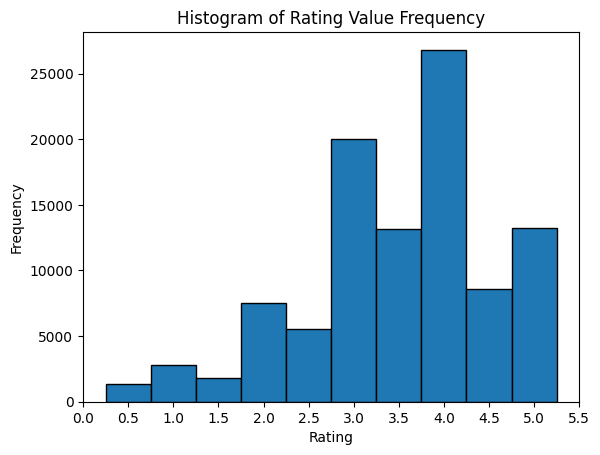

In [ ]:
rating_values = movie_ratings['rating']
unique_rating_values = rating_values.unique()
unique_rating_values.sort()
print('Possible Rating Values:', unique_rating_values)
unique_rating_values_frequency = []
for i in range(len(unique_rating_values)):
  unique_rating_values_frequency.append(len(rating_values[rating_values == unique_rating_values[i]]))
print('Frequency of Each Rating Value:', unique_rating_values_frequency)
plt.bar(unique_rating_values, unique_rating_values_frequency, width=0.5, edgecolor='black')
plt.xlabel('Rating')
plt.xticks(np.arange(0,6,0.5))
plt.ylabel('Frequency')
plt.title('Histogram of Rating Value Frequency')
plt.show()

C) The distribution of the number of ratings received among movies is plotted below.

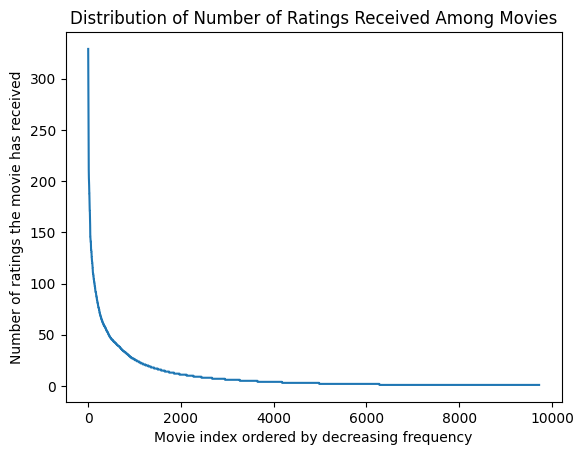

In [ ]:
num_movies = len(unique_movieIds)
num_ratings_per_movie = []
for i in range(num_movies):
  num_ratings_per_movie.append(len(movieIds[movieIds == unique_movieIds[i]]))
num_ratings_per_movie.sort(reverse=True)
plt.plot(range(1, num_movies+1), num_ratings_per_movie)
plt.xlabel('Movie index ordered by decreasing frequency')
plt.ylabel('Number of ratings the movie has received')
plt.title('Distribution of Number of Ratings Received Among Movies')
plt.show()

D) The distribution of ratings among users is plotted below.

Text(0.5, 1.0, 'Distribution of Ratings Among Users')

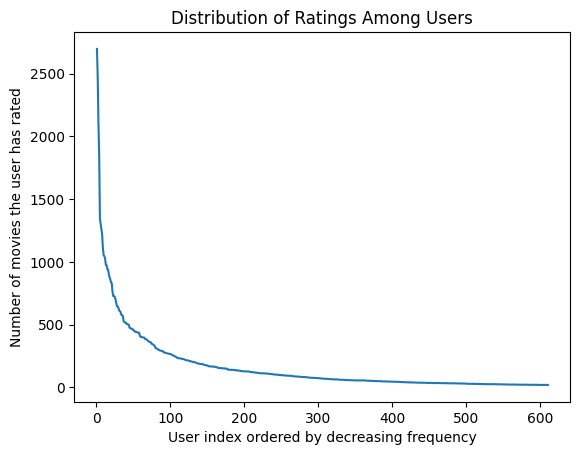

In [ ]:
num_users = len(unique_userIds)
num_ratings_per_user = []
for i in range(num_users):
  num_ratings_per_user.append(len(userIds[userIds == unique_userIds[i]]))
num_ratings_per_user.sort(reverse=True)
plt.plot(range(1, num_users+1), num_ratings_per_user)
plt.xlabel('User index ordered by decreasing frequency')
plt.ylabel('Number of movies the user has rated')
plt.title('Distribution of Ratings Among Users')

E) In the distribution plotted for Question C, we see that the curve is exponentially decreasing, meaning there are a small portion of movies that received a large and significant number of ratings, while the rest of the movies received comparatively very little ratings. Given the context of the dataset, this pattern makes sense because there are likely a small subset of movies that are well-known, causing many users to watch them and provide ratings for them. On the other hand, movies that don't fall into this small subset of well-known movies receive little attention from users, and the small number of ratings associated with them is reflective of this. The distribution plotted for Question D shows a similar pattern of exponential decline. Essentially, this means that a small subset of users are very active, providing many ratings for many different movies. On the other hand, users which don't fall into this small subset are less active, and only provide ratings for a few movies. Emphasizing this point, even though there are 9724 movies and 610 users, only about 1000 of thees movies received more than 25 user ratings and only about 120 of these users rated more than 250 movies. What this implies is that we will have to take movies which we have a lot of rating information for and extrapolate this data to similar movies wihch don't have as much rating information. In a similar manner, we will have to take users that we have lots of rating information on and extrapolate this knowledge to make recommendations for similar users that are not as active with rating movies. Essentailly, a small subset of movies and a small subset of users will be providing most of the data for our recommendation patterns, and these patterns will have to be extended to other movies and users for which we don't have as much rating data for.

F) We have computed the variance of the rating values received by each movie and plotted the resulting histogram below. By observing the histogram, we can see that out of 9724 movies, about 6000 have a rating variance between 0 and 0.5, about 2200 have a rating variance between 0.5 and 1.0, about 1000 have a rating variance between 1.0 and 1.5, and the remaining movies have a variance greater than 1.5. Therefore, about 9200 of the 9724 movies have a rating variance below 1.5. The shape of the histogram is like a hill that starts at the peak, then rapidly decreases before saturating close to 0 once reaching a variance of about 4.0. This tells us that for most movies, the variance of ratings is rather small, meaning that most users generally tend to agree on the approximate rating it deserves. There are only a small number of movies for which users have trouble agreeing on the approximate rating to give it.

5.0625
0.0


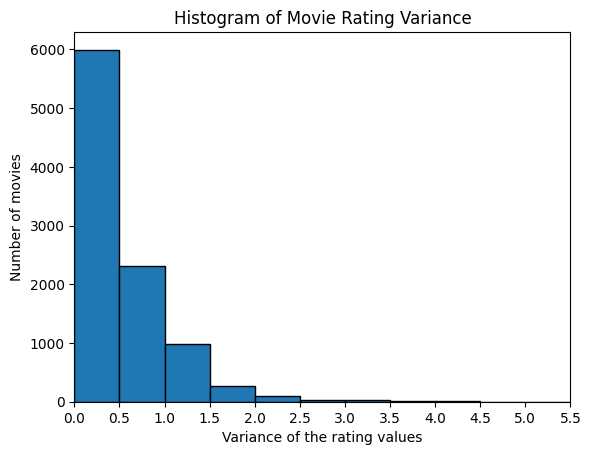

In [ ]:
variance_list = []
for i in range(num_movies):
  variance_list.append(np.var(movie_ratings['rating'][movie_ratings['movieId'] == unique_movieIds[i]]))
print(max(variance_list)) # 5.0625
print(min(variance_list)) # 0.0

plt.hist(variance_list, bins=np.arange(0,6.0,0.5), width=0.5, edgecolor='black')
plt.xticks(np.arange(0,6.0,0.5))
plt.xlim([0, 5.5])
plt.xlabel('Variance of the rating values')
plt.ylabel('Number of movies')
plt.title('Histogram of Movie Rating Variance')
plt.show()

#Neighborhood-based collaborative filtering

##Q2 Understanding the Pearson Correlation Coefficient

A) The formula for $\mu_u$ can be given as:

$$
\mu_u = \frac{\sum_{k \in I_u} r_{uk}}{|I_u|}
$$

In other words, sum all rating $r_{uk}$ values for which item $k$ is a part of the set $I_u$, then divide that by the number of elements in the set $I_u$.

B) The meaning of $I_u \cap I_v$ is the set of item indices that represent the items contained in *both* set $I_u$ AND set $I_v$. Yes, it is possible for $I_u \cap I_v = \emptyset$ because it's possible that there may not be a single item for which both user $u$ and user $v$ provided a rating for. This can happen if one user or both users have not rated any items, or if they've each rated an exlusive set of items with no items in common.

##Q3 Understanding the Prediction function

The reason behind mean-centering the raw ratings ($r_{vj} - \mu_v$) in the prediction function is to ensure that we capture more of a user $v$'s specific rating/thoughts towards an item $j$ rather than their overall, average rating tendencies as a whole. Therefore, if a user $v$ has rated an item $j$ the same as their overall mean ratings, then we can discard the term (cancels to zero) because the rating is more indicative of their overall rating pattern and less informative about their thoughts on the actual item itself. Additionally, without mean centering the ***formula would not work*** if we keep the first term in the formula, $\mu_u$, because all ratings would add on to this mean rating value $\mu_u$ positively, whereas mean-centering allows some terms to be negative, thus decreasing the predicted rating $\hat{r}_{uj}$ via subtraction from this mean rating value $\mu_u$ as appropriate.

Finally, let's consider the cases where user $v$ rates almost all items very positively (around 4.5-5) or very negatively (around 0.5-1). In the first case, them rating item $j$ highly is not very informative as they rate most items highly anyways, but if they give it a low rating it becomes extra important as it stands out from their usual patterns. In the second case, them rating item $j$ poorly is not very informative as they rate most items poorly anyways, but if they give it a high rating it becomes extra important as it stands out from their usual patterns.

##Q4 Designing a k-NN collaborative filter

The training and testing of a k-NN collaborative filter using 10-fold cross validation is performed below. This process was repeated for all k values from 2 to 100 in step sizes of 2. Then, the average RMSE against different k values was plotted and the average MAE against different k values was plotted.

In [ ]:
reader = Reader(sep=',',rating_scale=(0.5, 5))
processed_movie_ratings = movie_ratings[['userId', 'movieId', 'rating']]
data = Dataset.load_from_df(df=processed_movie_ratings,reader=reader)
k_values = np.arange(2, 101, 2)

In [ ]:
avg_rmse_list = []
avg_mae_list = []
for k in k_values:
    print('Testing for k =', k)
    sim_options = {'name': 'pearson', 'user_based': True}
    algo = KNNWithMeans(k=k, sim_options=sim_options)
    res = cross_validate(algo, data, measures=['rmse', 'mae'], cv=10, n_jobs=-1)
    avg_rmse_list.append(np.mean(res['test_rmse']))
    avg_mae_list.append(np.mean(res['test_mae']))

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50
Testing for k = 52
Testing for k = 54
Testing for k = 56
Testing for k = 58
Testing for k = 60
Testing for k = 62
Testing for k = 64
Testing for k = 66
Testing for k = 68
Testing for k = 70
Testing for k = 72
Testing for k = 74
Testing for k = 76
Testing for k = 78
Testing for k = 80
Testing for k = 82
Testing for k = 84
Testing for k = 86
Testing for k = 88
Testing for k = 90
Testing for k = 92
Testing for k = 94
Testing for k = 96
Testing for k = 98
Testing for k = 100


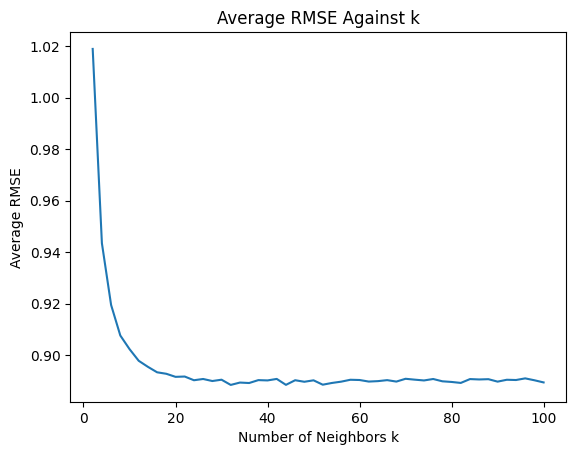

In [ ]:
plt.plot(k_values, avg_rmse_list)
plt.xlabel('Number of Neighbors k')
plt.ylabel('Average RMSE')
plt.title('Average RMSE Against k')
plt.show()

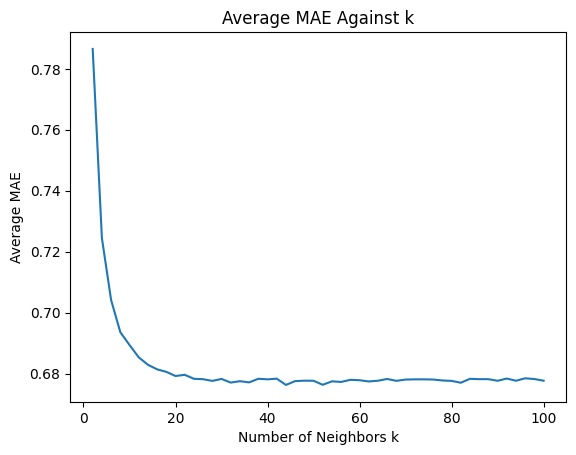

In [ ]:
plt.plot(k_values, avg_mae_list)
plt.xlabel('Number of Neighbors k')
plt.ylabel('Average MAE')
plt.title('Average MAE Against k')
plt.show()

##Q5 Finding a minimum k

By observing the two plots above, we can see that ***a good choice for a 'minimum k' is k=25***. This is because at this value of k, both the average RMSE and the average MAE saturate, and increasing k any further does not lead to any significant decrease in average RMSE or average MAE. Thus, this value of k gives us the steady-state values for both metrics. ***The steady-state value of average RMSE is 0.89 and the steady-state value of average MAE is 0.68.***

##Q6 Training and validating a k-NN collaborative filter within each of 3 trimmed subsets

The average RMSE plots for k values ranging from 2 to 100 with a step size of 2 are plotted below for a Popular Movie trimmed dataset, Unpopular Movie trimmed dataset, and High Variance Movie trimmed dataset. The Minimum Average RMSE of each trimming style is reported underneath its corresponding plot.

The ROC curves for all trimming styles as well as no trimming at all have also been plotted. The threshold values used for each of these plots were 2.5, 3, 3.5, and 4. The AUC corresponding to each of these threshold can be found in the plot's legend.

In [ ]:
unique_movieIds.sort()
popular_movie_list = []
for i in range(len(unique_movieIds)):
  num_ratings = len(movieIds[movieIds == unique_movieIds[i]])
  if num_ratings > 2:
    popular_movie_list.append(unique_movieIds[i])
processed_movie_ratings_popular = processed_movie_ratings[processed_movie_ratings['movieId'].isin(popular_movie_list)]
print(processed_movie_ratings_popular.shape)

(94794, 3)


In [ ]:
data_popular = Dataset.load_from_df(df=processed_movie_ratings_popular,reader=reader)
kf = KFold(n_splits=10)
avg_rmse_list_popular = []
for k in k_values:
  print('Testing for k =', k)
  sim_options = {'name': 'pearson', 'user_based': True}
  algo = KNNWithMeans(k=k, sim_options=sim_options, verbose=False)
  rmse_for_split = []
  for trainset, testset in kf.split(data_popular):
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse_for_split.append(accuracy.rmse(predictions, verbose=False))
  avg_rmse_list_popular.append(np.mean(rmse_for_split))

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50
Testing for k = 52
Testing for k = 54
Testing for k = 56
Testing for k = 58
Testing for k = 60
Testing for k = 62
Testing for k = 64
Testing for k = 66
Testing for k = 68
Testing for k = 70
Testing for k = 72
Testing for k = 74
Testing for k = 76
Testing for k = 78
Testing for k = 80
Testing for k = 82
Testing for k = 84
Testing for k = 86
Testing for k = 88
Testing for k = 90
Testing for k = 92
Testing for k = 94
Testing for k = 96
Testing for k = 98
Testing for k = 100


In [ ]:
unpopular_movie_list = []
for i in range(len(unique_movieIds)):
  num_ratings = len(movieIds[movieIds == unique_movieIds[i]])
  if num_ratings <= 2:
    unpopular_movie_list.append(unique_movieIds[i])
processed_movie_ratings_unpopular = processed_movie_ratings[processed_movie_ratings['movieId'].isin(unpopular_movie_list)]
print(processed_movie_ratings_unpopular.shape)

(6042, 3)


In [ ]:
data_unpopular = Dataset.load_from_df(df=processed_movie_ratings_unpopular,reader=reader)
kf = KFold(n_splits=10)
avg_rmse_list_unpopular = []
for k in k_values:
  print('Testing for k =', k)
  sim_options = {'name': 'pearson', 'user_based': True}
  algo = KNNWithMeans(k=k, sim_options=sim_options, verbose=False)
  rmse_for_split = []
  for trainset, testset in kf.split(data_unpopular):
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse_for_split.append(accuracy.rmse(predictions, verbose=False))
  avg_rmse_list_unpopular.append(np.mean(rmse_for_split))

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50
Testing for k = 52
Testing for k = 54
Testing for k = 56
Testing for k = 58
Testing for k = 60
Testing for k = 62
Testing for k = 64
Testing for k = 66
Testing for k = 68
Testing for k = 70
Testing for k = 72
Testing for k = 74
Testing for k = 76
Testing for k = 78
Testing for k = 80
Testing for k = 82
Testing for k = 84
Testing for k = 86
Testing for k = 88
Testing for k = 90
Testing for k = 92
Testing for k = 94
Testing for k = 96
Testing for k = 98
Testing for k = 100


In [ ]:
high_variance_movie_list = []
for i in range(len(unique_movieIds)):
  variance = np.var(movie_ratings['rating'][movie_ratings['movieId'] == unique_movieIds[i]])
  num_ratings = len(movieIds[movieIds == unique_movieIds[i]])
  if variance >= 2 and num_ratings >= 5:
    high_variance_movie_list.append(unique_movieIds[i])
processed_movie_ratings_high_variance = processed_movie_ratings[processed_movie_ratings['movieId'].isin(high_variance_movie_list)]
print(processed_movie_ratings_high_variance.shape)

(250, 3)


In [ ]:
data_high_variance = Dataset.load_from_df(df=processed_movie_ratings_high_variance,reader=reader)
kf = KFold(n_splits=10)
avg_rmse_list_high_variance = []
for k in k_values:
  print('Testing for k =', k)
  sim_options = {'name': 'pearson', 'user_based': True}
  algo = KNNWithMeans(k=k, sim_options=sim_options, verbose=False)
  rmse_for_split = []
  for trainset, testset in kf.split(data_high_variance):
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse_for_split.append(accuracy.rmse(predictions, verbose=False))
  avg_rmse_list_high_variance.append(np.mean(rmse_for_split))

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50
Testing for k = 52
Testing for k = 54
Testing for k = 56
Testing for k = 58
Testing for k = 60
Testing for k = 62
Testing for k = 64
Testing for k = 66
Testing for k = 68
Testing for k = 70
Testing for k = 72
Testing for k = 74
Testing for k = 76
Testing for k = 78
Testing for k = 80
Testing for k = 82
Testing for k = 84
Testing for k = 86
Testing for k = 88
Testing for k = 90
Testing for k = 92
Testing for k = 94
Testing for k = 96
Testing for k = 98
Testing for k = 100


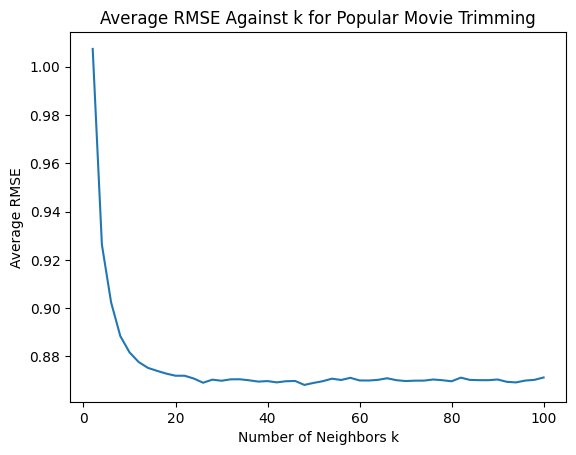

Minimum Average RMSE for Popular Trimming: 0.868222201569923


In [ ]:
plt.plot(k_values, avg_rmse_list_popular)
plt.xlabel('Number of Neighbors k')
plt.ylabel('Average RMSE')
plt.title('Average RMSE Against k for Popular Movie Trimming')
plt.show()
print('Minimum Average RMSE for Popular Trimming:', min(avg_rmse_list_popular))

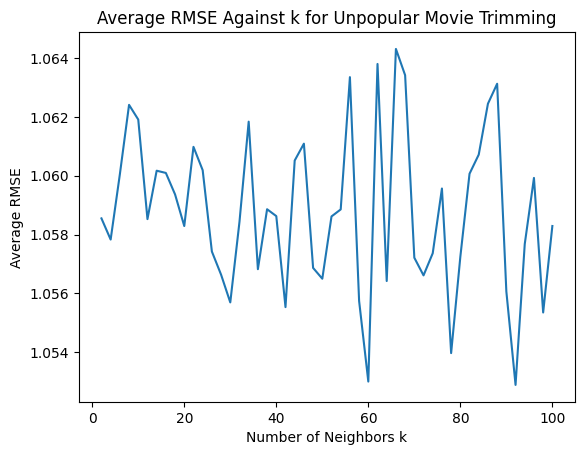

Minimum Average RMSE for Unpopular Trimming: 1.0528914915829497


In [ ]:
plt.plot(k_values, avg_rmse_list_unpopular)
plt.xlabel('Number of Neighbors k')
plt.ylabel('Average RMSE')
plt.title('Average RMSE Against k for Unpopular Movie Trimming')
plt.show()
print('Minimum Average RMSE for Unpopular Trimming:', min(avg_rmse_list_unpopular))

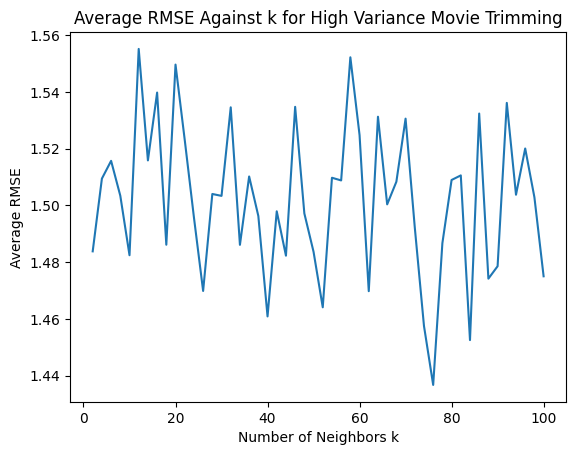

Minimum Average RMSE for High Variance Trimming: 1.4366965289123832


In [ ]:
plt.plot(k_values, avg_rmse_list_high_variance)
plt.xlabel('Number of Neighbors k')
plt.ylabel('Average RMSE')
plt.title('Average RMSE Against k for High Variance Movie Trimming')
plt.show()
print('Minimum Average RMSE for High Variance Trimming:', min(avg_rmse_list_high_variance))

In [ ]:
thresholds = [2.5, 3.0, 3.5, 4.0]
trainset, testset = train_test_split(data, test_size=0.1)
sim_options = {'name': 'pearson', 'user_based': True}
algo = KNNWithMeans(k=25, sim_options=sim_options, verbose=False)
algo.fit(trainset)
predictions = algo.test(testset)

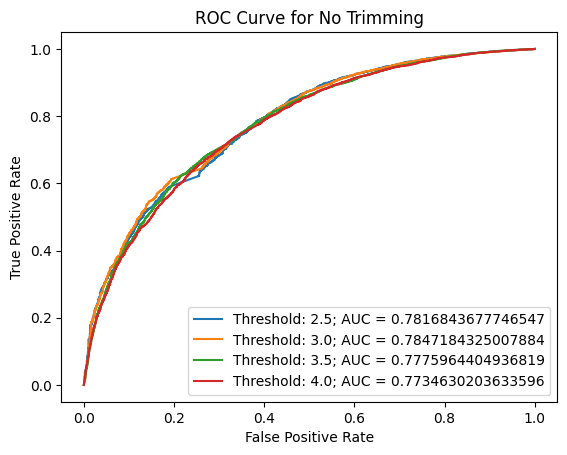

In [ ]:
true_ratings = [row.r_ui for row in predictions]
predicted_ratings = [row.est for row in predictions]
for threshold in thresholds:
  true_labels = []
  for i in range(len(true_ratings)):
    if true_ratings[i] >= threshold:
      true_labels.append(1)
    else:
      true_labels.append(0)
  fpr, tpr, _ = roc_curve(true_labels, predicted_ratings)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='Threshold: ' + str(threshold) + '; AUC = ' + str(roc_auc))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for No Trimming')
plt.show()

In [ ]:
trainset, testset = train_test_split(data_popular, test_size=0.1)
sim_options = {'name': 'pearson', 'user_based': True}
algo = KNNWithMeans(k=25, sim_options=sim_options, verbose=False)
algo.fit(trainset)
predictions = algo.test(testset)

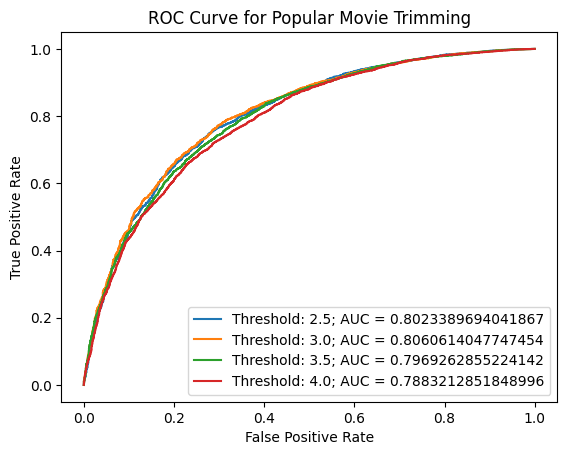

In [ ]:
true_ratings = [row.r_ui for row in predictions]
predicted_ratings = [row.est for row in predictions]
for threshold in thresholds:
  true_labels = []
  for i in range(len(true_ratings)):
    if true_ratings[i] >= threshold:
      true_labels.append(1)
    else:
      true_labels.append(0)
  fpr, tpr, _ = roc_curve(true_labels, predicted_ratings)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='Threshold: ' + str(threshold) + '; AUC = ' + str(roc_auc))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Popular Movie Trimming')
plt.show()

In [ ]:
trainset, testset = train_test_split(data_unpopular, test_size=0.1)
sim_options = {'name': 'pearson', 'user_based': True}
algo = KNNWithMeans(k=25, sim_options=sim_options, verbose=False)
algo.fit(trainset)
predictions = algo.test(testset)

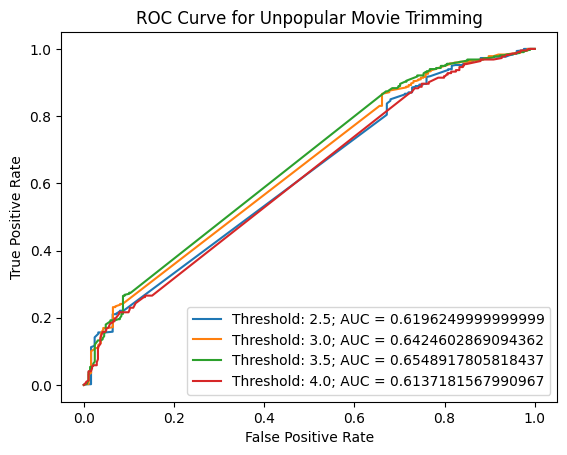

In [ ]:
true_ratings = [row.r_ui for row in predictions]
predicted_ratings = [row.est for row in predictions]
for threshold in thresholds:
  true_labels = []
  for i in range(len(true_ratings)):
    if true_ratings[i] >= threshold:
      true_labels.append(1)
    else:
      true_labels.append(0)
  fpr, tpr, _ = roc_curve(true_labels, predicted_ratings)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='Threshold: ' + str(threshold) + '; AUC = ' + str(roc_auc))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Unpopular Movie Trimming')
plt.show()

In [ ]:
trainset, testset = train_test_split(data_high_variance, test_size=0.1)
sim_options = {'name': 'pearson', 'user_based': True}
algo = KNNWithMeans(k=25, sim_options=sim_options, verbose=False)
algo.fit(trainset)
predictions = algo.test(testset)

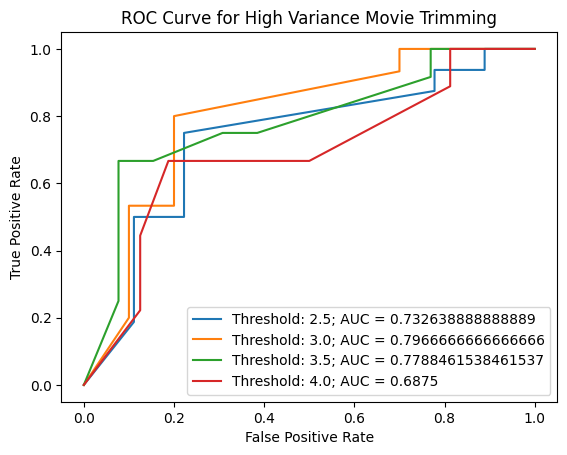

In [ ]:
true_ratings = [row.r_ui for row in predictions]
predicted_ratings = [row.est for row in predictions]
for threshold in thresholds:
  true_labels = []
  for i in range(len(true_ratings)):
    if true_ratings[i] >= threshold:
      true_labels.append(1)
    else:
      true_labels.append(0)
  fpr, tpr, _ = roc_curve(true_labels, predicted_ratings)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='Threshold: ' + str(threshold) + '; AUC = ' + str(roc_auc))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for High Variance Movie Trimming')
plt.show()

#Model-based collaborative filtering

##Non-negative matrix factorization (NMF)

##Q7


No,The optimization problem described is not convex when considering both matrices U and V as unknown variables simultaneously. This is because the problem involves optimizing with respect to both matrices at once, leading to a scenario where the objective function does not exhibit a single global minimum due to the presence of multiple local minima. However, if we fix one of these matrices and solve for the other, the problem can be reformulated into a convex least-squares problem. Therefore, while the optimization problem is not jointly convex with respect to both U and V due to the potential for multiple local minima, it becomes convex when addressing each matrix individually.


In [ ]:
!pip install scikit-surprise

##Q8


For the NMF Collaborative Filter model, both RMSE and MAE metrics exhibit a similar trend when plotted against the number of latent factors,
k. Initially, as k increases, the error decreases, indicating an improvement in the model's predictive accuracy. However, beyond a certain point, the error begins to rise again, displaying a linear increase. This phenomenon suggests that simply increasing
k does not necessarily enhance performance and may indeed be counterproductive due to the curse of dimensionality. With higher
k values, the dimensionality of the model increases, leading to a more complex and potentially noisier rating matrix.

Minimum average RMSE (NMF): 0.914353, value of k: 16 <br>
Minimum average MAE (NMF): 0.693310, value of k: 20

For the Popular Trimming, the lowest average RMSE observed was 0.8699042681391524, indicating that the dataset trimmed for popular movies outperformed the untrimmed original set. Where the average RMSE initially decreases before increasing with the number of latent factors, suggests that the addition of principal components beyond a certain point does not add meaningful information and instead introduces noise. Initially, the error decreases as the model captures more relevant information, but as
k increases further, the error begins to rise due to overfitting and the inherent limitations of NMF, including high information loss from enforcing non-negativity, which impacts its effectiveness at higher dimensions.

For the Unpopular Trimming, the minimum average RMSE was 1.598643274858693, significantly higher than that observed for the popularly trimmed dataset. As depicted in The average RMSE exhibits slight fluctuations rather than a consistent decrease. This irregular behavior can be attributed to the presence of outliers, with the model struggling to accurately predict ratings for less commonly rated items due to insufficient data.

For the High Variance Trimming, the minimum average RMSE significantly increased to 1.598643274858693, marking the poorest performance among the datasets. The trend, is not only non-monotonic but also highly erratic. This is because the subset includes movies with a wide range of ratings, making the model overly sensitive to outliers and consequently leading to a higher prediction error. This highlights the challenges in modeling data with high variance in ratings, where the predictor's accuracy is severely compromised.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import roc_curve, auc, mean_squared_error
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

ac = '/content/drive/Shareddrives/ECE219/Project3/Synthetic_Movie_Lens/'
rd = pd.read_csv(ac+"ratings.csv",index_col = 0)
from pathlib import Path
filepath = Path('/content/drive/Shareddrives/ECE219/Project3/data1.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
rd.to_csv(filepath,index = False)

reader = Reader(line_format='user item rating timestamp',sep=',',rating_scale=(0.5, 5),skip_lines=1)
ratings_dataset = Dataset.load_from_file('/content/drive/Shareddrives/ECE219/Project3/data1.csv',reader = reader)


Ratings_file = pd.read_csv(df+"ratings.csv",usecols=['userId','movieId','rating'])


k = np.arange(2,52,2)
rmse_NMF = []
mae_NMF = []
for item in k:
    print('Testing for k =',item)
    res = cross_validate(NMF(n_factors=item,n_epochs=50,verbose=False), measures=['rmse','mae'],data = ratings_dataset,cv=10,n_jobs=-1)
    rmse_NMF.append(np.mean(res['test_rmse']))
    mae_NMF.append(np.mean(res['test_mae']))

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50


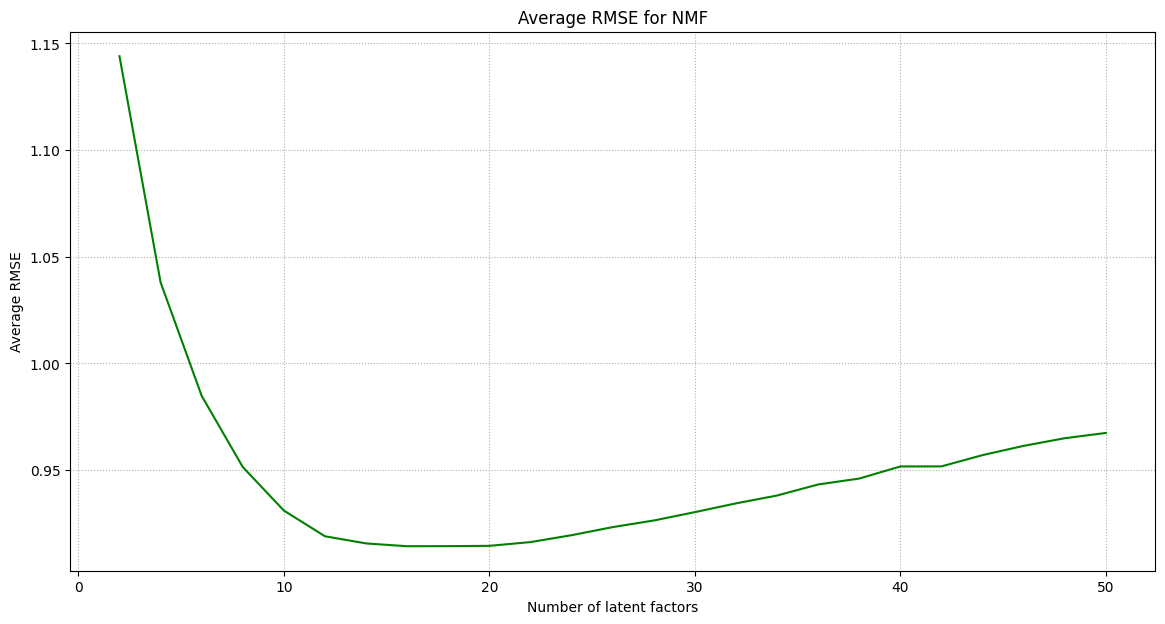

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(k,rmse_NMF,color='g')
plt.grid(linestyle=':')
plt.title('Average RMSE for NMF')
plt.ylabel('Average RMSE')
plt.xlabel('Number of latent factors')
plt.savefig('Q8a.png',dpi=500,bbox_inches='tight')
plt.show()

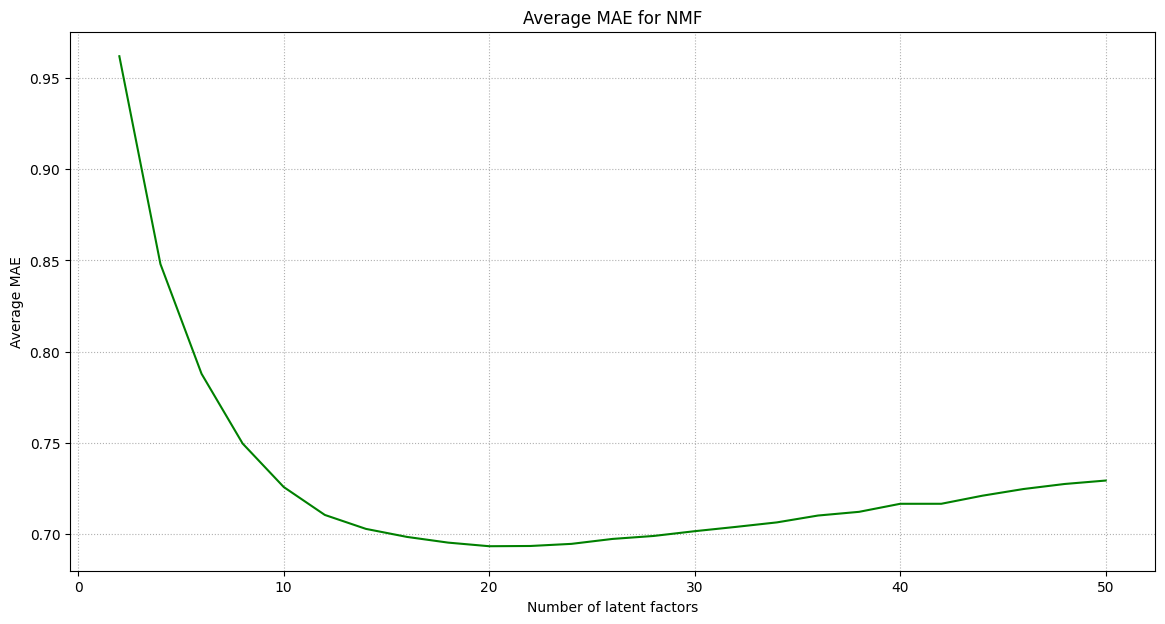

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(k,mae_NMF,color='g')
plt.grid(linestyle=':')
plt.title('Average MAE for NMF')
plt.ylabel('Average MAE')
plt.xlabel('Number of latent factors')
plt.savefig('Q8b.png',dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
print("Minimum average RMSE (NMF): %f, value of k: %d" % (min(rmse_NMF),k[[i for i, x in enumerate(rmse_NMF) if x == min(rmse_NMF)][0]]))
print("Minimum average MAE (NMF): %f, value of k: %d" % (min(mae_NMF),k[[i for i, x in enumerate(mae_NMF) if x == min(mae_NMF)][0]]))

Minimum average RMSE (NMF): 0.914353, value of k: 16
Minimum average MAE (NMF): 0.693310, value of k: 20


In [ ]:
rmse_NMF_popular = []
kf = KFold(n_splits=10)

for item in k:
    local_rmse = []
    print('Testing for k =', item)
    for trainset, testset in kf.split(ratings_dataset):
        trim_list = []
        unique, counts = np.unique([row[1] for row in testset], return_counts=True)
        for i in range(len(counts)):
            if counts[i] <= 2:
                trim_list.append(unique[i])
        trimmed_set = [j for j in testset if j[1] not in trim_list]
        model = NMF(n_factors=item, n_epochs=50, verbose=False)
        model.fit(trainset)
        predictions = model.test(trimmed_set)
        local_rmse.append(accuracy.rmse(predictions, verbose=False))
    rmse_NMF_popular.append(np.mean(local_rmse))

# Optionally, you could print or plot the results similar to the previous example
print("RMSE for NMF with popularity-based trimming:", rmse_NMF_popular)

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50
RMSE for NMF with popularity-based trimming: [1.1407418287040072, 1.0171357955141274, 0.9476988133441019, 0.9109770158671047, 0.891315183597224, 0.8767237412596597, 0.8699042681391524, 0.8728272153669948, 0.8709407230877698, 0.8739310484965686, 0.8785717077689833, 0.8823613130353051, 0.8867530162539687, 0.8924166172344178, 0.8955363180896352, 0.9058004976587632, 0.9079997674717827, 0.9133739216972542, 0.9177744170131295, 0.9219121461734096, 0.929785920893688, 0.9287474445886807, 0.9345145380218394, 0.9417264974626051, 0.946

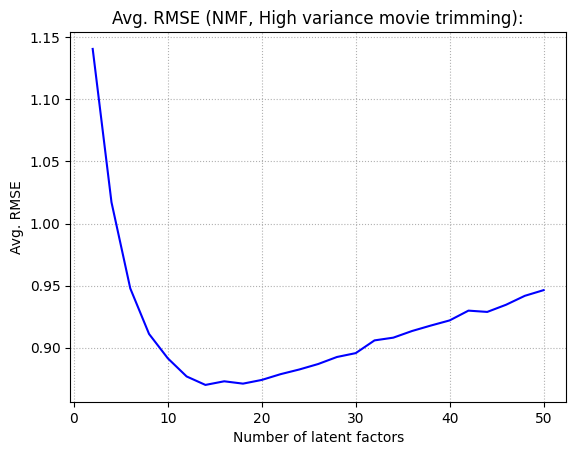

In [ ]:
plt.plot(k,rmse_NMF_popular, color='b')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (NMF, High variance movie trimming):')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of latent factors')
plt.savefig('Q21.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
print("Minimum avg. RMSE (NMF, Popular movie trimming):", min(rmse_NMF_popular))

Minimum avg. RMSE (NMF, Popular movie trimming): 0.8699042681391524


In [ ]:
item_variances = {}
for j in ratings_dataset.raw_ratings:
    item_id, rating = j[1], j[2]
    if item_id in item_variances:
        item_variances[item_id].append(rating)
    else:
        item_variances[item_id] = [rating]

# Keep only items with variance >= 2 and at least 5 ratings
filtered_items = {item: ratings for item, ratings in item_variances.items() if np.var(ratings) >= 2 and len(ratings) >= 5}

rmse_NMF_var = []
kf = KFold(n_splits=10)

for item in k:
    local_rmse = []
    print('Testing for k =', item)
    for trainset, testset in kf.split(ratings_dataset):
        # Trim test set based on pre-computed criteria
        trimmed_set = [j for j in testset if j[1] in filtered_items]
        model = NMF(n_factors=item, n_epochs=50, verbose=False)
        model.fit(trainset)
        predictions = model.test(trimmed_set)
        local_rmse.append(accuracy.rmse(predictions, verbose=False))
    rmse_NMF_var.append(np.mean(local_rmse))

# Output the results
print("RMSE for NMF with variance-based trimming:", rmse_NMF_var)

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50
RMSE for NMF with variance-based trimming: [1.6980534898733335, 1.7702385141698596, 1.6277093274402634, 1.675635449005884, 1.6531692937893958, 1.7475541130619496, 1.625545948140828, 1.6839504740608675, 1.7522686444921038, 1.6667937388486145, 1.7430504450394722, 1.6455421617311732, 1.6766328264068118, 1.7104584193175305, 1.598643274858693, 1.7341923989340575, 1.6783950802856196, 1.630597930084182, 1.621316372578503, 1.6853436563131736, 1.7158470807571913, 1.730307807896357, 1.7104297769546304, 1.6752430042903115, 1.687541012

In [ ]:
print("Minimum avg. RMSE (NMF, Popular movie trimming):", min(rmse_NMF_var))

Minimum avg. RMSE (NMF, Popular movie trimming): 1.598643274858693


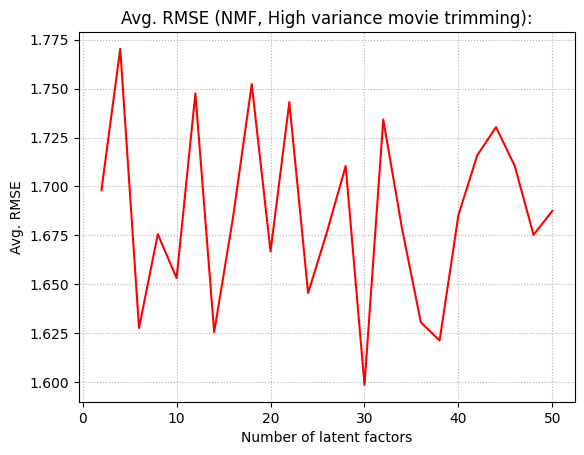

Minimum avg. RMSE (NMF, High variance movie trimming): 1.598643274858693


In [ ]:
plt.plot(k,rmse_NMF_var,color='r')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (NMF, High variance movie trimming):')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of latent factors')
plt.savefig('Q21.png',dpi=300,bbox_inches='tight')
plt.show()
print("Minimum avg. RMSE (NMF, High variance movie trimming):", min(rmse_NMF_var))

In [ ]:
min_rmse_index = np.argmin(rmse_NMF)  # This gets the index of the minimum RMSE
optimal_k = k[min_rmse_index]  # This uses the index to find the corresponding k

# Now you can use optimal_k for further operations
thres = [1, 2, 3, 4, 5]
trainset, testset = train_test_split(ratings_dataset, test_size=0.1)
model = NMF(n_factors=optimal_k, n_epochs=50, verbose=False)
model.fit(trainset)
predictions = model.test(testset)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


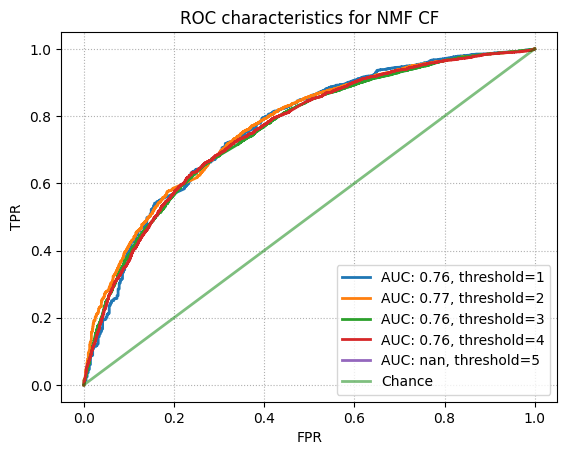

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
trainset, testset = train_test_split(ratings_dataset, test_size=0.1)

# Initialize NMF model with the optimal number of latent factors
model = NMF(n_factors=optimal_k, n_epochs=50, verbose=False)
model.fit(trainset)
res = model.test(testset)
fig, ax = plt.subplots()

for item in thres:
    # Binarize the actual ratings based on the current threshold
    thresholded_out = [1 if row.r_ui > item else 0 for row in res]

    # Compute the ROC curve and AUC for the current threshold
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    current_auc = auc(fpr, tpr)

    # Plot the ROC curve for the current threshold
    ax.plot(fpr, tpr, lw=2, label=f"AUC: {current_auc:.2f}, threshold={item}")

# Plot the chance line
ax.plot([0, 1], [0, 1], lw=2, color='g', label='Chance', alpha=.5)

# Finalize the plot
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for NMF CF')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

##Q9

Upon reviewing the genres of the top 10 movies across selected latent factors, it emerged that these movies often clustered within particular genres or a limited set of closely related genres. This trend indicates that the NMF model's latent factors may indeed capture underlying thematic or stylistic elements common to groups of movies, thereby aligning these factors closely with distinct genre categories.

In [ ]:
# Load the movies dataset
df = '/content/drive/Shareddrives/ECE219/Project3/Synthetic_Movie_Lens/'
genre = pd.read_csv(df + 'movies.csv', usecols=['movieId', 'title', 'genres'])

trainset = ratings_dataset.build_full_trainset()  # Use the full dataset for training
nmf = NMF(n_factors=20, n_epochs=50, verbose=False)
nmf.fit(trainset)

# User-latent and Movie-latent factors interaction matrices
U = nmf.pu  # User-latent factors
V = nmf.qi  # Movie-latent factors

# Selected latent factors to analyze
cols = [1, 3, 5, 7, 11, 15, 19]  # Adjusted for zero-based indexing


for item in cols:
    print('Column number of V: ',item)
    selected_col = V[:,item]
    sorted_col = np.argsort(selected_col)[::-1]
    for i in sorted_col[0:10]:
        print(genre['genres'][i])


Column number of V:  1
Children|Comedy
Action|Crime|Thriller|IMAX
Drama
Documentary
Action
Action|Drama|Romance|Thriller
Comedy
Adventure|Drama|Romance
Animation|Children|Fantasy|Musical|Romance
Adventure|Children|Comedy
Column number of V:  3
Drama
Animation|Children|Comedy
Comedy|Drama|Romance
Action|Adventure|Drama
Drama
Horror|Sci-Fi
Fantasy
Drama
Children|Fantasy|Musical
Action|Drama|Thriller
Column number of V:  5
Children|Comedy
Action|Animation|Sci-Fi
Documentary|Drama
Action|Drama
Comedy|Drama|Romance
Comedy
Action|Adventure|Thriller|IMAX
Action|Animation|Fantasy|Sci-Fi
Drama|Romance
Action|Adventure|Comedy|Crime|Drama
Column number of V:  7
Comedy|Romance
Documentary
Comedy|Crime
Drama|Horror|Mystery|Thriller
Comedy|Drama
Adventure|Drama|Romance
Drama|Romance
Comedy|Drama
Action|Crime|Thriller
Comedy
Column number of V:  11
Adventure|Animation|Comedy|Fantasy|Romance|Sci-Fi
Comedy|Drama|Romance
Drama|Romance
Drama|Mystery|Thriller
Comedy
Drama
Animation|Documentary|Drama|War
C

##Matrix factorization with bias (MF with bias)


##Q10

Minimum avg. RMSE (SVD): 0.865406, value of k: 20 <br>
Minimum avg. MAE (SVD): 0.664329, value of k: 20

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50


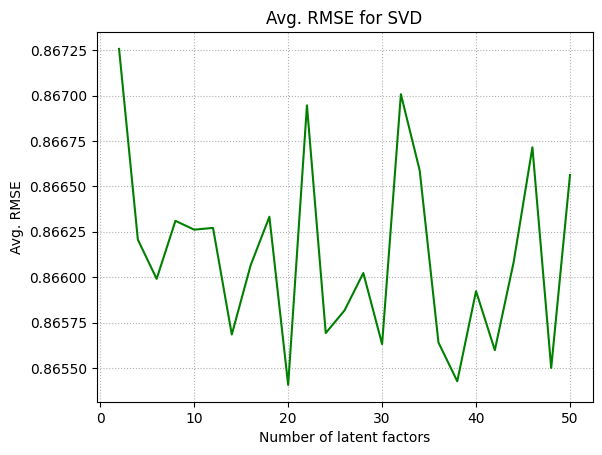

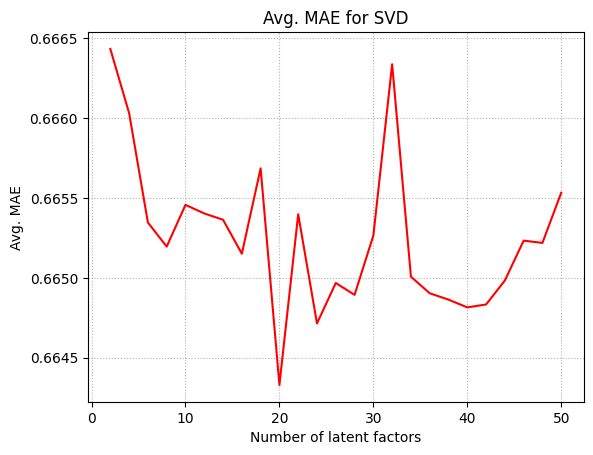

In [ ]:
k = np.arange(2,52,2)
rmse_SVD = []
mae_SVD = []
for item in k:
    print('Testing for k =',item)
    res = cross_validate(SVD(n_factors=item,n_epochs=20,verbose=False), measures=['rmse','mae'],data = ratings_dataset,cv=10,n_jobs=-1)
    rmse_SVD.append(np.mean(res['test_rmse']))
    mae_SVD.append(np.mean(res['test_mae']))
plt.plot(k,rmse_SVD,color='g')
plt.grid(linestyle=':')
plt.title('Avg. RMSE for SVD')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of latent factors')
plt.show()

plt.plot(k,mae_SVD,color='r')
plt.grid(linestyle=':')
plt.title('Avg. MAE for SVD')
plt.ylabel('Avg. MAE')
plt.xlabel('Number of latent factors')
plt.show()

In [ ]:
print("Minimum avg. RMSE (SVD): %f, value of k: %d" % (min(rmse_SVD),k[[i for i, x in enumerate(rmse_SVD) if x == min(rmse_SVD)][0]]))
print("Minimum avg. MAE (SVD): %f, value of k: %d" % (min(mae_SVD),k[[i for i, x in enumerate(mae_SVD) if x == min(mae_SVD)][0]]))


Minimum avg. RMSE (SVD): 0.865406, value of k: 20
Minimum avg. MAE (SVD): 0.664329, value of k: 20


POPULAR TRIMMING

In [ ]:

rmse_SVD_pop = []
# Initialize KFold for cross-validation
kf = KFold(n_splits=10)
for item in k:
    local_rmse = []
    print(f'Testing for k = {item}')

    for trainset, testset in kf.split(ratings_dataset):
        # Create a dictionary with movie IDs as keys and their rating counts in the test set as values
        movie_rating_counts = {}
        for _, movieID, _ in testset:
            movie_rating_counts[movieID] = movie_rating_counts.get(movieID, 0) + 1

        # Trim the test set to include only movies with more than 2 ratings
        trimmed_testset = [rating for rating in testset if movie_rating_counts[rating[1]] > 2]

        # Fit the SVD model and make predictions on the trimmed test set
        model = SVD(n_factors=item, n_epochs=20, verbose=False)
        model.fit(trainset)
        predictions = model.test(trimmed_testset)

        # Compute RMSE for this fold and add it to the local_rmse list
        fold_rmse = accuracy.rmse(predictions, verbose=False)
        local_rmse.append(fold_rmse)

    # Compute the average RMSE for this value of k and add it to the rmse_SVD_pop list
    avg_rmse = np.mean(local_rmse)
    rmse_SVD_pop.append(avg_rmse)

# Output the results
print(f'Average RMSE for popular movies trimmed test set: {rmse_SVD_pop}')

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50
Average RMSE for popular movies trimmed test set: [0.8514939887104834, 0.851364859875219, 0.8492556139232781, 0.8486443090119291, 0.8482265821017044, 0.8472109195881445, 0.8484051357299359, 0.8470532295977442, 0.8486301085797404, 0.84854936740936, 0.8495349561452296, 0.8473098829905764, 0.8489333229367964, 0.8485308450235515, 0.850225536149645, 0.8485876519466455, 0.8507124371056504, 0.8481736237158468, 0.8465432940272122, 0.8478092656893924, 0.8484496626613393, 0.8465207729892015, 0.8471004084860789, 0.8480895808420632, 0.

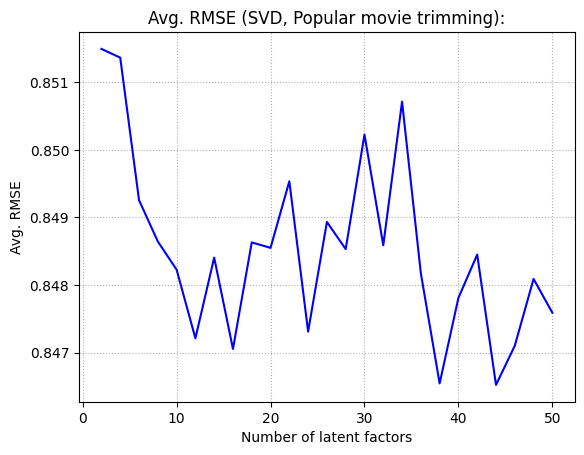

Minimum avg. RMSE (SVD, Popular movie trimming): 0.8465207729892015


In [ ]:

plt.plot(k,rmse_SVD_pop,color='b')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (SVD, Popular movie trimming):')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of latent factors')
plt.show()
print("Minimum avg. RMSE (SVD, Popular movie trimming):", min(rmse_SVD_pop))

UNPOPULAR TRIMMING

In [ ]:
rmse_SVD_unpop = []

# Initialize KFold for cross-validation
kf = KFold(n_splits=10)

for item in k:
    local_rmse = []
    print(f'Testing for k = {item}')

    for trainset, testset in kf.split(ratings_dataset):
        # Create a dictionary with movie IDs as keys and their rating counts in the test set as values
        movie_rating_counts = {}
        for _, movieID, _ in testset:
            movie_rating_counts[movieID] = movie_rating_counts.get(movieID, 0) + 1

        # Trim the test set to include only movies with 2 or fewer ratings
        trimmed_testset = [rating for rating in testset if movie_rating_counts[rating[1]] <= 2]

        # Fit the SVD model and make predictions on the trimmed test set
        model = SVD(n_factors=item, n_epochs=20, verbose=False)
        model.fit(trainset)
        predictions = model.test(trimmed_testset)

        # Compute RMSE for this fold and add it to the local_rmse list
        fold_rmse = accuracy.rmse(predictions, verbose=False)
        local_rmse.append(fold_rmse)

    # Compute the average RMSE for this value of k and add it to the rmse_SVD_unpop list
    avg_rmse = np.mean(local_rmse)
    rmse_SVD_unpop.append(avg_rmse)

# Output the results
print(f'Average RMSE for unpopular movies trimmed test set: {rmse_SVD_unpop}')

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50
Average RMSE for unpopular movies trimmed test set: [0.9005555481740739, 0.9001598025209411, 0.9033847561810205, 0.903334166055956, 0.9017746645766851, 0.9027656197770394, 0.9040988125821924, 0.9041148942623826, 0.9025734588789567, 0.9030999526717609, 0.8964325463408889, 0.9040930872905033, 0.9038560186284814, 0.9024612503290796, 0.9057933288961333, 0.9069630537537098, 0.9049940824788537, 0.9019260176108137, 0.9015108940381136, 0.9039406984636988, 0.9034443708865117, 0.9058681607149554, 0.9071271819113399, 0.905811621469977

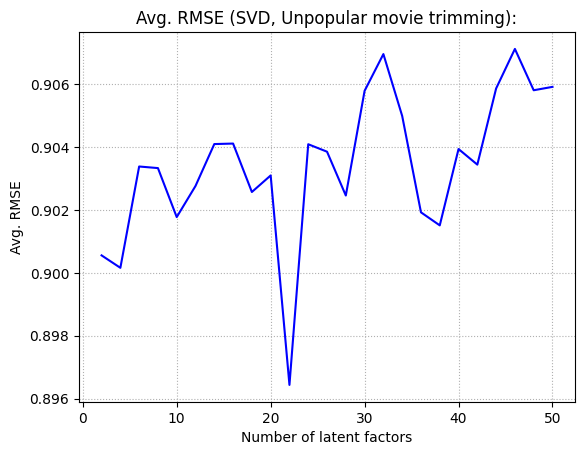

Minimum avg. RMSE (SVD, Unpopular movie trimming): 0.8964325463408889


In [ ]:

plt.plot(k,rmse_SVD_unpop,color='b')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (SVD, Unpopular movie trimming):')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of latent factors')
plt.show()

print("Minimum avg. RMSE (SVD, Unpopular movie trimming):", min(rmse_SVD_unpop))

HIGH VARIANCE TRIMMING

In [ ]:
rmse_SVD_var = []

# Initialize KFold for cross-validation
kf = KFold(n_splits=10)

# Pre-compute variance and rating counts for all movies in the dataset
movie_variances = {}
for j in ratings_dataset.raw_ratings:
    movie_id, rating = j[1], j[2]
    if movie_id not in movie_variances:
        movie_variances[movie_id] = []
    movie_variances[movie_id].append(rating)

movie_variances = {movie: np.var(ratings) for movie, ratings in movie_variances.items() if len(ratings) >= 5}

for item in k:
    local_rmse = []
    print(f'Testing for k = {item}')

    for trainset, testset in kf.split(ratings_dataset):
        # Trim the test set to include only high-variance movies (variance >= 2 and at least 5 ratings)
        trimmed_testset = [rating for rating in testset if movie_variances.get(rating[1], 0) >= 2]

        # Fit the SVD model and make predictions on the trimmed test set
        model = SVD(n_factors=item, n_epochs=20, verbose=False)
        model.fit(trainset)
        predictions = model.test(trimmed_testset)

        # Compute RMSE for this fold and add it to the local_rmse list
        fold_rmse = accuracy.rmse(predictions, verbose=False)
        local_rmse.append(fold_rmse)

    # Compute the average RMSE for this value of k and add it to the rmse_SVD_var list
    avg_rmse = np.mean(local_rmse)
    rmse_SVD_var.append(avg_rmse)

# Output the results
print(f'Average RMSE for high-variance movies trimmed test set: {rmse_SVD_var}')

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50
Average RMSE for high-variance movies trimmed test set: [1.4686634969930492, 1.4873197371648015, 1.4842469284796658, 1.4801339580550739, 1.470391460951616, 1.4848516634998066, 1.4678001971721724, 1.4761562390424041, 1.4711038871183086, 1.4755577614168578, 1.4871696920860684, 1.477259943411568, 1.4736518439630746, 1.4734983836044484, 1.4792472483109798, 1.4752209129242888, 1.4713462387982017, 1.4797832442656607, 1.4879317694119525, 1.4980481036403692, 1.4470095111241776, 1.475610826508584, 1.445245204013721, 1.47053270387331

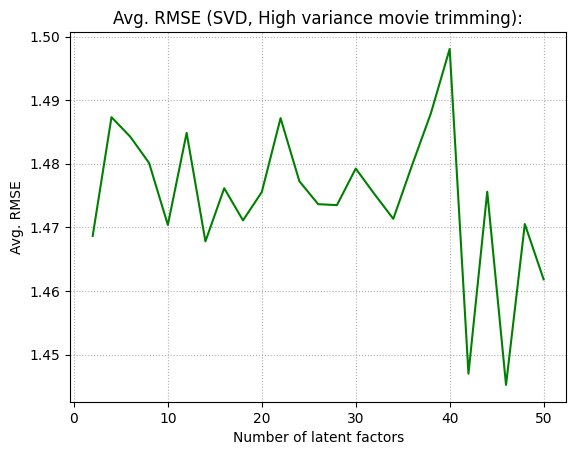

Minimum avg. RMSE (SVD, High variance movie trimming): 1.445245204013721


In [ ]:
plt.plot(k,rmse_SVD_var,color='g')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (SVD, High variance movie trimming):')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of latent factors')
plt.show()
print("Minimum avg. RMSE (SVD, High variance movie trimming):", min(rmse_SVD_var))

ROC CURVE

In [ ]:
k = k[[i for i, x in enumerate(rmse_SVD) if x == min(rmse_SVD)][0]]
thres = [1, 2, 3, 4, 5 ]
trainset, testset = train_test_split(ratings_dataset, test_size=0.1)
res  = SVD(n_factors=k,n_epochs=20,verbose=False).fit(trainset).test(testset)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


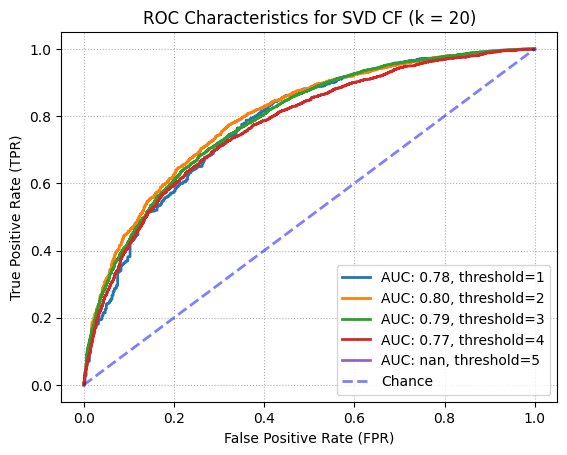

In [ ]:
fig, ax = plt.subplots()

for item in thres:
    # Binarize the actual ratings based on the threshold
    thresholded_out = [1 if row.r_ui > item else 0 for row in res]
    estimated_ratings = [row.est for row in res]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(thresholded_out, estimated_ratings)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    ax.plot(fpr, tpr, lw=2, label=f"AUC: {roc_auc:.2f}, threshold={item}")

# Plot chance line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b', label='Chance', alpha=.5)

plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title(f'ROC Characteristics for SVD CF (k = {k})')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

#Naive collaborative filtering

##Q11

In [ ]:
from sklearn.metrics import mean_squared_error
from surprise import Dataset, Reader
from surprise.model_selection import KFold
import numpy as np

user_ID = Ratings_file['userId'].values
movie_ID = Ratings_file['movieId'].values
rating = Ratings_file['rating'].values

# Calculate sparsity
sparsity = len(rating) / (len(set(movie_ID)) * len(set(user_ID)))
print(f'Sparsity: {sparsity}')
user_ID = Ratings_file['userId'].values
movie_ID = Ratings_file['movieId'].values
rating = Ratings_file['rating'].values

mean_ratings_per_user = {user: np.mean(rating[user_ID == user]) for user in np.unique(user_ID)}

# Setup for cross-validation
kf = KFold(n_splits=10)

def evaluate_naive_approach(ratings_dataset, mean_ratings_per_user, trim_func=None):
    rmse_values = []
    for trainset, testset in kf.split(ratings_dataset):
        # Optionally trim the testset based on a provided function
        if trim_func is not None:
            testset = trim_func(testset, trainset)
        predictions = [mean_ratings_per_user.get(str(row[0]), np.mean(list(mean_ratings_per_user.values()))) for row in testset]
        actual_ratings = [row[2] for row in testset]

        rmse_values.append(mean_squared_error(actual_ratings, predictions, squared=False))

    return np.mean(rmse_values)

# Evaluate on the entire dataset without trimming
rmse_naive = evaluate_naive_approach(ratings_dataset, mean_ratings_per_user)
print(f'Avg. RMSE for Naive Filtering: {rmse_naive}')

Sparsity: 0.016999683055613623
Avg. RMSE for Naive Filtering: 1.0540629337034328


In [ ]:
kf = KFold(n_splits=10)

def trim_unpopular(testset, trainset):
    movie_counts = {}
    for _, movieID, _ in trainset.all_ratings():
        raw_movie_id = trainset.to_raw_iid(movieID)
        movie_counts[raw_movie_id] = movie_counts.get(raw_movie_id, 0) + 1
    return [rating for rating in testset if movie_counts.get(str(rating[1]), 0) <= 2]

def evaluate_naive_approach_unpopular(ratings_dataset, mean_ratings_per_user):
    local_rmse = []
    for trainset, testset in kf.split(ratings_dataset):
        trimmed_testset = trim_unpopular(testset, trainset)

        predictions = [mean_ratings_per_user.get(str(row[0]), np.mean(list(mean_ratings_per_user.values()))) for row in trimmed_testset]
        actual_ratings = [row[2] for row in trimmed_testset]
        local_rmse.append(mean_squared_error(actual_ratings, predictions, squared=False))

    return np.mean(local_rmse)
rmse_naive_unpop = evaluate_naive_approach_unpopular(ratings_dataset, mean_ratings_per_user)
print(f'Avg. RMSE for Naive Filtering (Unpopular movie trimming): {rmse_naive_unpop}')

Avg. RMSE for Naive Filtering (Unpopular movie trimming): 1.1879583567731404


In [ ]:
from surprise.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

movie_ratings = {}
for uid, iid, rating, _ in ratings_dataset.raw_ratings:
    movie_ratings.setdefault(iid, []).append(rating)
movie_variances = {movie: np.var(ratings) for movie, ratings in movie_ratings.items() if len(ratings) >= 5}

def trim_high_variance(testset, _):
    # Filter based on variance without converting IDs
    return [rating for rating in testset if str(rating[1]) in movie_variances]
def evaluate_naive_approach_high_variance(ratings_dataset, mean_ratings_per_user):
    local_rmse = []
    kf = KFold(n_splits=10)
    for trainset, testset in kf.split(ratings_dataset):
        trimmed_testset = trim_high_variance(testset, trainset)

        predictions = [mean_ratings_per_user.get(str(row[0]), np.mean(list(mean_ratings_per_user.values()))) for row in trimmed_testset]
        actual_ratings = [row[2] for row in trimmed_testset]
        local_rmse.append(mean_squared_error(actual_ratings, predictions, squared=False))

    return np.mean(local_rmse)
rmse_naive_var = evaluate_naive_approach_high_variance(ratings_dataset, mean_ratings_per_user)
print(f'Avg. RMSE for Naive Filtering (High-variance movie trimming): {rmse_naive_var}')

Avg. RMSE for Naive Filtering (High-variance movie trimming): 1.0367661528383887


#Performance comparison

##Q12
k-NN, NMF, and MF performance comparison plot has been plotted below. Their ROC curve values at threshold of 3 are relatively the same, [KNN, NMF, MF] -> [0.78, 0.76, 0.79]. Overall, MF model seems to have a slightly better performance according to a higher ROC value.

In [2]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163008 sha256=188b6ff60bc5eca4056181d0e0332fbf95a7f17f24a67e6667f4527996d10406
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [6]:
import matplotlib.pyplot as plt
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
from surprise.prediction_algorithms.knns import KNNWithMeans

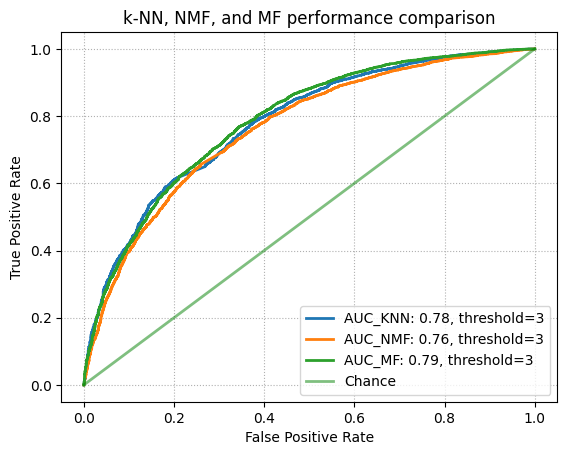

In [11]:
# read file
reader = Reader(line_format='user item rating timestamp',sep=',',rating_scale=(0.5, 5),skip_lines=1)
ratings_dataset = Dataset.load_from_file('/content/drive/Shareddrives/ECE219/Project3/data1.csv',reader = reader)
trainset, testset = train_test_split(ratings_dataset, test_size=0.1)

# define variables
thres = [3]

# KNN model
sim_options = {'name': 'pearson', 'user_based': True}
algo = KNNWithMeans(k=25, sim_options=sim_options, verbose=False)
algo.fit(trainset)
pred_knn = algo.test(testset)
true_ratings = [row.r_ui for row in pred_knn]
predicted_ratings = [row.est for row in pred_knn]

# NMF model
optimal_k_knn = 16
model_nmf = NMF(n_factors=optimal_k_knn, n_epochs=50, verbose=False)
model_nmf.fit(trainset)
pred_nmf = model_nmf.test(testset)

# MF model
optimal_k_mf = 20
pred_mf  = SVD(n_factors=optimal_k_mf,n_epochs=20,verbose=False).fit(trainset).test(testset)

# plot
fig, ax = plt.subplots()
for threshold in thres:
  # KNN model
  true_labels = []
  for i in range(len(true_ratings)):
    if true_ratings[i] >= threshold:
      true_labels.append(1)
    else:
      true_labels.append(0)

  fpr, tpr, _ = roc_curve(true_labels, predicted_ratings)
  roc_auc = auc(fpr, tpr)
  ax.plot(fpr, tpr, lw=2, label=f"AUC_KNN: {roc_auc:.2f}, threshold={threshold}")

  # NMF model
  thresholded_out = [1 if row.r_ui > threshold else 0 for row in pred_nmf]
  fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in pred_nmf])
  roc_auc = auc(fpr, tpr)
  ax.plot(fpr, tpr, lw=2, label=f"AUC_NMF: {roc_auc:.2f}, threshold={threshold}")


  # MF model
  thresholded_out = [1 if row.r_ui > threshold else 0 for row in pred_mf]
  estimated_ratings = [row.est for row in pred_mf]
  fpr, tpr, thresholds = roc_curve(thresholded_out, estimated_ratings)
  roc_auc = auc(fpr, tpr)
  ax.plot(fpr, tpr, lw=2, label=f"AUC_MF: {roc_auc:.2f}, threshold={threshold}")

  # Plot the chance line
  ax.plot([0, 1], [0, 1], lw=2, color='g', label='Chance', alpha=.5)

  # Finalize the plot
  plt.legend(loc='best')
  plt.grid(linestyle=':')
  plt.title('k-NN, NMF, and MF performance comparison')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()


#Ranking

In [1]:
# mount google drive for dataset access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Q13 Data Understanding and Preprocessing
Print the number of unique queries in total and show distribution of relevance labels below

In [ ]:
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score
import numpy as np

# Load the dataset for one fold
def load_one_folder(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    _, group_train = np.unique(qid_train, return_counts=True) # return (unique element, counts)
    _, group_test = np.unique(qid_test, return_counts=True) # return (unique element, counts)
    return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test

def ndcg_single_query(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

# calculate NDCG score given a trained model
def compute_ndcg_all(model, X_test, y_test, qids_test, k):
    unique_qids = np.unique(qids_test)
    ndcg_ = list()
    for i, qid in enumerate(unique_qids):
        y = y_test[qids_test == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_test[qids_test == qid])

        idcg = ndcg_single_query(y, y, k=k)
        ndcg_.append(ndcg_single_query(p, y, k=k) / idcg)
    return np.mean(ndcg_)

# get importance of features
def get_feature_importance(model, importance_type='gain'):
    return model.feature_importance(importance_type=importance_type)

In [ ]:
# save all folders variable into file
from scipy import sparse
import numpy as np

for idx in range(1,6):
  folder_path = '/content/drive/Shareddrives/ECE219/Project3/MSLR_WEB10K/Fold' + str(idx) + '/'
  X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = load_one_folder(folder_path)

  # save train_set
  sparse.save_npz(('mydata/X_train_f' + str(idx) + '.npz'), X_train)
  np.save(('mydata/y_train_f' + str(idx) + '.npy'), y_train)
  np.save(('mydata/qid_train_f' + str(idx) + '.npy'), qid_train)
  np.save(('mydata/group_train_f' + str(idx) + '.npy'), group_train)

  # save test_set
  sparse.save_npz(('mydata/X_test_f' + str(idx) + '.npz'), X_test)
  np.save(('mydata/y_test_f' + str(idx) + '.npy'), y_test)
  np.save(('mydata/qid_test_f' + str(idx) + '.npy'), qid_test)
  np.save(('mydata/group_test_f' + str(idx) + '.npy'), group_test)

  print('folder ' + str(idx) + 'complete')


folder 1complete
folder 2complete
folder 3complete
folder 4complete
folder 5complete


In [ ]:
# load variables from file
from scipy import sparse
import numpy as np

data_path = '/content/drive/Shareddrives/ECE219/Project3/mydata'

def load_folder(idx):
  # load train_set
  X_train = sparse.load_npz(data_path + '/X_train_f' + str(idx) + '.npz')
  y_train = np.load(data_path + '/y_train_f' + str(idx) + '.npy')
  qid_train = np.load(data_path + '/qid_train_f' + str(idx) + '.npy')
  group_train = np.load(data_path + '/group_train_f' + str(idx) + '.npy')

  # load test_set
  X_test = sparse.load_npz(data_path + '/X_test_f' + str(idx) + '.npz')
  y_test = np.load(data_path + '/y_test_f' + str(idx) + '.npy')
  qid_test = np.load(data_path + '/qid_test_f' + str(idx) + '.npy')
  group_test = np.load(data_path + '/group_test_f' + str(idx) + '.npy')

  return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test

# load in five folders
X_train = []
y_train = []
qid_train = []
group_train = []
X_test = []
y_test = []
qid_test = []
group_test = []

for idx in range(1,6): # file idx from 1 to 5
  tr1, tr2, tr3, tr4, te1, te2, te3, te4 = load_folder(idx)
  X_train.append(tr1)
  y_train.append(tr2)
  qid_train.append(tr3)
  group_train.append(tr4)
  X_test.append(te1)
  y_test.append(te2)
  qid_test.append(te3)
  group_test.append(te4)
  print('load folder ', idx, ' complete')


load folder  1  complete
load folder  2  complete
load folder  3  complete
load folder  4  complete
load folder  5  complete


In [ ]:
# print properties
for idx in range(5):
  print('-'*20)
  print('Training set in folder ', idx+1)
  print('Number of unique queries:', group_train[idx].shape)
  print('Relevance labels:', y_train[idx])
  print(' ')
  print('Testing set in folder ', idx+1)
  print('Number of unique queries:', group_test[idx].shape)
  print('Relevance labels:', y_test[idx])
  print('-'*20)

--------------------
Training set in folder  1
Number of unique queries: (6000,)
Relevance labels: [2 2 0 ... 0 0 1]
 
Testing set in folder  1
Number of unique queries: (2000,)
Relevance labels: [2 1 3 ... 1 0 0]
--------------------
--------------------
Training set in folder  2
Number of unique queries: (6000,)
Relevance labels: [0 0 0 ... 1 2 1]
 
Testing set in folder  2
Number of unique queries: (2000,)
Relevance labels: [2 2 0 ... 0 1 1]
--------------------
--------------------
Training set in folder  3
Number of unique queries: (6000,)
Relevance labels: [0 0 1 ... 1 0 0]
 
Testing set in folder  3
Number of unique queries: (2000,)
Relevance labels: [0 0 0 ... 1 1 0]
--------------------
--------------------
Training set in folder  4
Number of unique queries: (6000,)
Relevance labels: [0 0 1 ... 0 1 1]
 
Testing set in folder  4
Number of unique queries: (2000,)
Relevance labels: [0 0 1 ... 0 0 1]
--------------------
--------------------
Training set in folder  5
Number of uni

##Q14 LightGBM Model Training
 Model’s performance on five folders in order of 3, 5, 10 have been printed below.

##Q15 Result Analysis and Interpretation
The top 5 features of each dataset folder are printed after the model performance below.

In [ ]:
!pip install lightgbm

In [ ]:
# define functions
import lightgbm as lgb
import pandas as pd

def train_model(X_train, y_train, group_train):
  param = { # define parameters
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'ndcg_eval_at': [3, 5, 10],
        }
  train_data = lgb.Dataset(X_train, label=y_train, group=group_train) # convert train_data
  bst = lgb.train(param, train_data) # training
  return bst

def evaluate_model(model, X_test, y_test, qids_test, k_values, folder_idx):
    # Calculate nDCG scores
    print('-'*20)
    print('Folder', folder_idx)
    for idx in k_values:
      ndcg_result = compute_ndcg_all(model, X_test, y_test, qids_test, idx)
      print('ndcg_order',idx, ':', ndcg_result)

def get_feature(bst):
  # compute importances
  importance_df = (
      pd.DataFrame({
          'feature_name': bst.feature_name(),
          'importance_gain': bst.feature_importance(importance_type='gain'),
      })
      .sort_values('importance_gain', ascending=False)
      .reset_index(drop=True)
  )
  return importance_df


In [ ]:
# train LightGBM models with 'lambdarank' objective
order_list = [3, 5, 10]
feature_list = []

for idx in range(5): # matrix idx from 0 to 4
  bst_model = train_model(X_train[idx], y_train[idx], group_train[idx])
  evaluate_model(bst_model, X_test[idx], y_test[idx], qid_test[idx], order_list, idx+1)
  model_feature = get_feature(bst_model)
  feature_list.append(model_feature)
  print(' ')
  print('Top 5 features:')
  print(model_feature.iloc[:5])
  print('-'*20)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.579821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25637
[LightGBM] [Info] Number of data points in the train set: 723412, number of used features: 136
--------------------
Folder 1
ndcg_order 3 : 0.4564571300800643
ndcg_order 5 : 0.4632890672260867
ndcg_order 10 : 0.48286731451235976
 
Top 5 features:
  feature_name  importance_gain
0   Column_133     23856.702951
1     Column_7      4248.546391
2   Column_107      4135.244450
3    Column_54      4078.463216
4   Column_129      3635.037024
--------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.050678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25623
[LightGBM] [Info] 

In [ ]:
# save featureList to file
import pickle

with open('feature_list.pkl', 'wb') as file:
  pickle.dump(feature_list, file)

##Q16 Experiments with Subset of Features
(1) Remove the top 20 features and retrain the model. NDCG socre of all folders decrease as expected. Intuitively, removing top features making it more difficult to identify one qurey from another, which makes sense that model perdormace downgrade from ndcg_score at around 0.5 to 0.3. <br>
(2) Remove the top 60 features and retrain the model. As explained above, the nscg scores decrerase as expected. However, it is not a rapid change from the previous case. The first folder for instance, [0.46, 0.46, 0.48] -> [0.38, 0.39, 0.40] -> [0.34, 0.35, 0.38]. The model performance of removing top 20 features and removing top 60 features are very colse, meaning that The extra 40 features does not affect model performance that much. Only a few features at the top significantly affecting the performance. The statement can be supported by observing the importance score of the top 5 features printed above. <br>

Top 5 features:<br>
  feature_name  importance_gain<br>
0   Column_133     23856.702951<br>
1     Column_7      4248.546391<br>
2   Column_107      4135.244450<br>
3    Column_54      4078.463216<br>
4   Column_129      3635.037024<br>

The top feature weights 5 times than the second feature.

In [ ]:
# remove feature function
def remove_feature(X_train, X_test, columns_to_remove):
  # Convert to a list of all column indices
  all_columns = list(range(X_train.shape[1]))

  # Find which columns to keep
  columns_to_keep = [col for col in all_columns if col not in columns_to_remove]

  # reduce dataset
  reduced_train = X_train[:, columns_to_keep]
  reduced_test = X_test[:, columns_to_keep]
  return reduced_train, reduced_test


In [ ]:
# Loading feature_list from the pickle file
import pickle

with open('feature_list.pkl', 'rb') as file:
  feature_list = pickle.load(file)

In [ ]:
# remove the top 20 features and retrain the model
order_list = [3, 5, 10]

for idx in range(5): # matrix idx from 0 to 4
  # retrive features
  top_20_feature_names = feature_list[idx]['feature_name'].head(20)
  top_20_indices = [int(name.split('_')[1]) for name in top_20_feature_names]

  # remove features
  X_train_reduced, X_test_reduced = remove_feature(X_train[idx], X_test[idx], top_20_indices)

  # retrain the model
  bst_model = train_model(X_train_reduced, y_train[idx], group_train[idx])
  evaluate_model(bst_model, X_test_reduced, y_test[idx], qid_test[idx], order_list, idx+1)
  print('-'*20)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.326594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21582
[LightGBM] [Info] Number of data points in the train set: 723412, number of used features: 116
--------------------
Folder 1
ndcg_order 3 : 0.37967488460229254
ndcg_order 5 : 0.3850299691938894
ndcg_order 10 : 0.4083636029390886
--------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.887943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21551
[LightGBM] [Info] Number of data points in the train set: 716683, number of used features: 116
--------------------
Folder 2
ndcg_order 3 : 0.3739449461043477
ndcg_order 5 : 0.3819536013454118
ndcg_order 10 : 0.4045026694861529


In [ ]:
# remove the top 60 features and retrain the model
order_list = [3, 5, 10]

for idx in range(5): # matrix idx from 0 to 4
  # retrive features
  top_60_feature_names = feature_list[idx]['feature_name'].head(60)
  top_60_indices = [int(name.split('_')[1]) for name in top_60_feature_names]

  # remove features
  X_train_reduced, X_test_reduced = remove_feature(X_train[idx], X_test[idx], top_60_indices)

  # retrain the model
  bst_model = train_model(X_train_reduced, y_train[idx], group_train[idx])
  evaluate_model(bst_model, X_test_reduced, y_test[idx], qid_test[idx], order_list, idx+1)
  print('-'*20)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.219537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13014
[LightGBM] [Info] Number of data points in the train set: 723412, number of used features: 76
--------------------
Folder 1
ndcg_order 3 : 0.33546915606221284
ndcg_order 5 : 0.34660877109472304
ndcg_order 10 : 0.3761216118110393
--------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.249899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12229
[LightGBM] [Info] Number of data points in the train set: 716683, number of used features: 76
--------------------
Folder 2
ndcg_order 3 : 0.33254089926505576
ndcg_order 5 : 0.3440485383851923
ndcg_order 10 : 0.3724982237661007
